# Regression Model

In this notebook we will build a simple multiple regression model which will be used as a baseline model for the comparision with the xGBoost Model

# 1. Data Loading and Package Installation

In [1]:
# Importing Packages 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing Data with Features 
data_hedonic = pd.read_csv ('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final.csv')
data_utilitarian = pd.read_csv ('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv')

In [3]:
data_hedonic.drop(['Unnamed: 0'], axis=1, inplace=True)
data_utilitarian.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
data_hedonic['sentiment_c'] = data_hedonic['Sentiment_Classification'].map(sentiment_mapping)
data_utilitarian['sentiment_c'] = data_hedonic['Sentiment_Classification'].map(sentiment_mapping)


In [5]:
# First we will simply sort all reviews that have at least one helpful Vote
data_utilitarian_helpful = data_utilitarian[data_utilitarian['helpful_vote'] > 0]
data_hedonic_helpful = data_hedonic[data_hedonic['helpful_vote'] > 0]


In [6]:
# Join dataframes
data_helpful = pd.concat([data_utilitarian_helpful, data_hedonic_helpful])

# 2. Building Regression Model for Utilitarian and Hedonic Product Type

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Define features and target
features = ['rating', 'sentiment_c', 'subjective_score', 'elap_days', 'image', 'ver_purch', 'word_count',
            'sent_count', 'sent_length', 'title_length', '#adj', '#adv', '#nouns', 'FRE']
target = 'helpful_ratio'

Mean Squared Error: 2.7236212458553468e-05
             Feature  Coefficient
0             rating     0.000027
1        sentiment_c    -0.000543
2   subjective_score     0.000178
3          elap_days     0.000683
4              image     0.000918
5          ver_purch     0.000319
6         word_count     0.001842
7         sent_count    -0.000225
8        sent_length     0.000100
9       title_length    -0.000066
10              #adj     0.000146
11              #adv     0.000090
12            #nouns     0.000200
13               FRE     0.000257
                            OLS Regression Results                            
Dep. Variable:          helpful_ratio   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.652
Date:                Mon, 27 May 2024   Prob (F-statistic):           6.13e-11
Time:                        09:06:29   Log-Likeliho

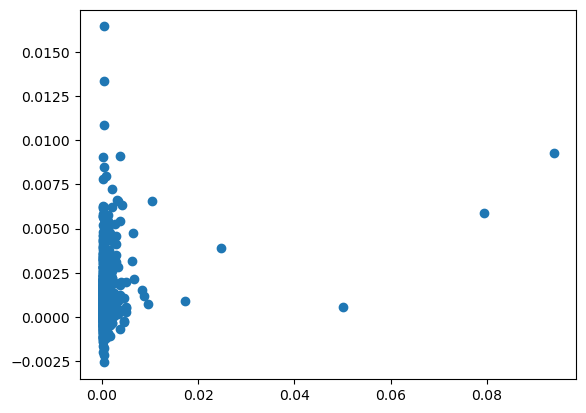

In [8]:
# Split data into training and testing sets
X = data_utilitarian_helpful[features]
y = data_utilitarian_helpful[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (Due to the different scales of the features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and fit the model using sklearn
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
plt.scatter(y_test, y_pred)

# Showing Coefficients
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

# Add a constant to the features matrix for the intercept term
X_train_const = sm.add_constant(X_train_scaled)

# Fit the linear regression model using statsmodels
model_utilitarian = sm.OLS(y_train, X_train_const).fit()

# Show regression results
print(model_utilitarian.summary())

# Extract p-values and identify significant features
p_values = model_utilitarian.pvalues
significant_features = p_values[p_values < 0.05].index
significant_features = significant_features[significant_features != 'const']  # Exclude the intercept
print("\nSignificant features based on p-values:")
print(significant_features)

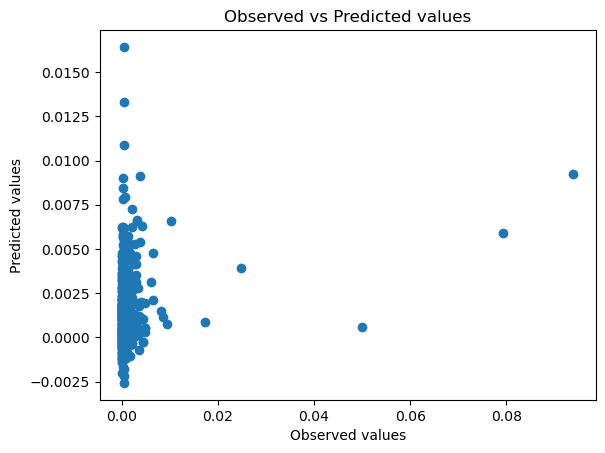

Durbin-Watson statistic: 2.0065429448936527


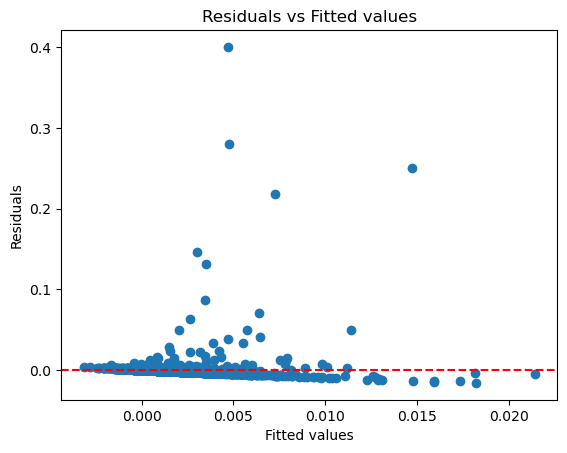

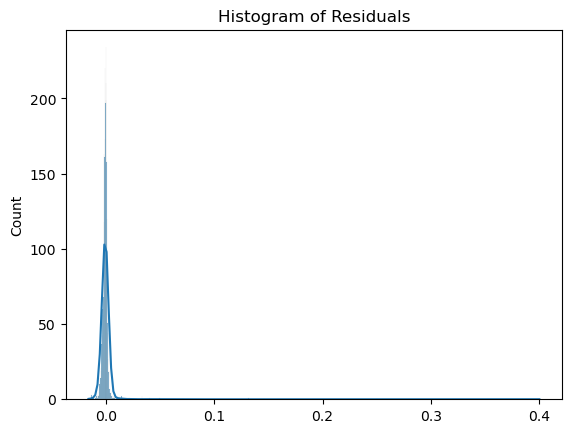

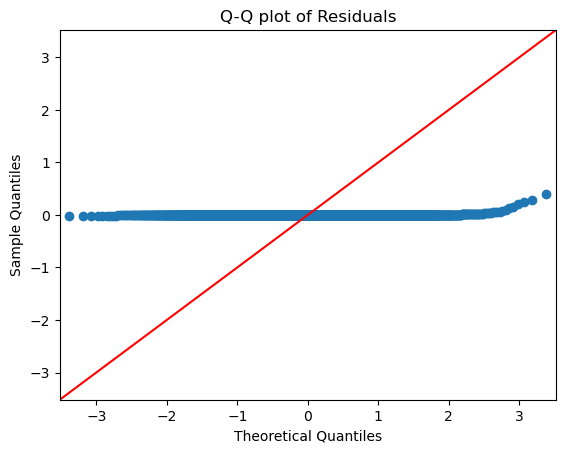

             feature        VIF
0             rating   4.104712
1        sentiment_c   5.170571
2   subjective_score  17.819689
3          elap_days   2.502790
4              image   1.083971
5          ver_purch  20.130474
6         word_count  11.536235
7         sent_count  13.461917
8        sent_length   5.052228
9       title_length   1.851001
10              #adj   3.111557
11              #adv   2.761488
12            #nouns   7.002139
13               FRE  20.451535


In [9]:
# Testing the assumptions of linear regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Linearity
# Plotting observed vs predicted values 
plt.scatter(y_test, y_pred)
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs Predicted values')
plt.show()

# 2. Independence
# Durbin-Watson statistic for autocorrelation
from statsmodels.stats.stattools import durbin_watson
print('Durbin-Watson statistic:', durbin_watson(model_utilitarian.resid))

# 3. Homoscedasticity
# Plotting residuals vs fitted values
plt.scatter(model_utilitarian.fittedvalues, model_utilitarian.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 4. Normality of Residuals
# Plotting histogram + Q-Q plot of residuals
sns.histplot(model_utilitarian.resid, kde=True)
plt.title('Histogram of Residuals')
plt.show()

sm.qqplot(model_utilitarian.resid, line ='45')
plt.title('Q-Q plot of Residuals')
plt.show()

# 5. No Multicollinearity
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [10]:
# Split data into training and testing sets
X = data_hedonic_helpful[features]
y = data_hedonic_helpful[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and fit the model using sklearn
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Interpret the results
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

# Add a constant to the features matrix for the intercept term
X_train_const = sm.add_constant(X_train_scaled)

# Fit the linear regression model using statsmodels
model_hedonic = sm.OLS(y_train, X_train_const).fit()

# Get the summary of the regression results
print(model_hedonic.summary())

# Extract p-values and identify significant features
p_values = model_hedonic.pvalues
significant_features = p_values[p_values < 0.05].index
significant_features = significant_features[significant_features != 'const']  # Exclude the intercept
print("\nSignificant features based on p-values:")
print(significant_features)


Mean Squared Error: 3.620824210459154e-05
             Feature  Coefficient
0             rating    -0.000191
1        sentiment_c     0.000022
2   subjective_score    -0.000036
3          elap_days     0.000052
4              image     0.000675
5          ver_purch     0.000290
6         word_count     0.000452
7         sent_count     0.000514
8        sent_length     0.000349
9       title_length     0.000164
10              #adj    -0.000059
11              #adv    -0.000171
12            #nouns    -0.000051
13               FRE    -0.000105
                            OLS Regression Results                            
Dep. Variable:          helpful_ratio   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     8.947
Date:                Mon, 27 May 2024   Prob (F-statistic):           1.67e-19
Time:                        09:06:31   Log-Likelihoo

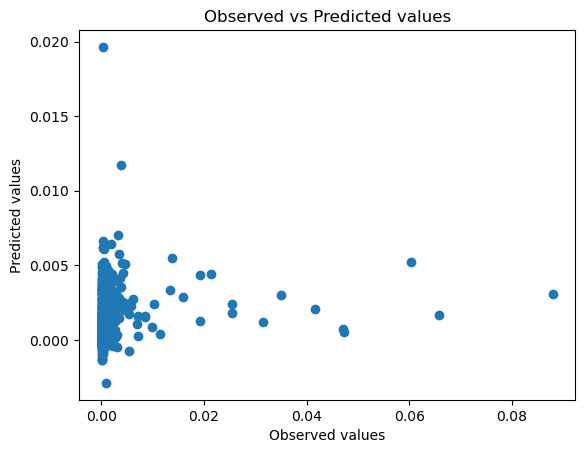

Durbin-Watson statistic: 2.0266116890955863


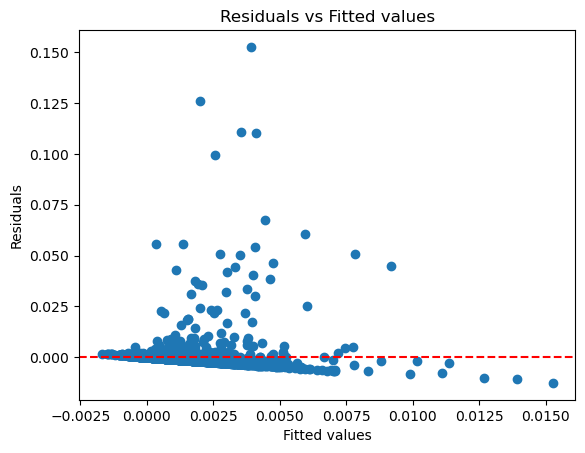

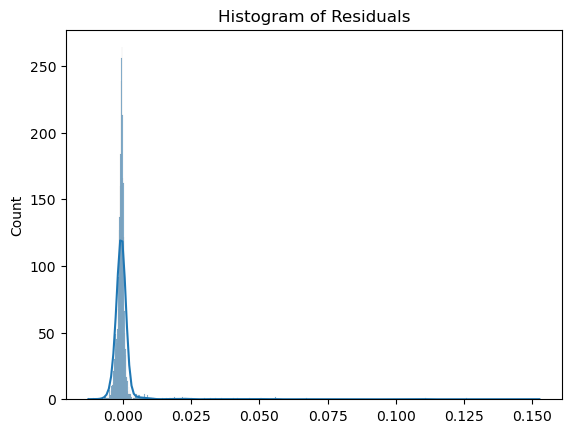

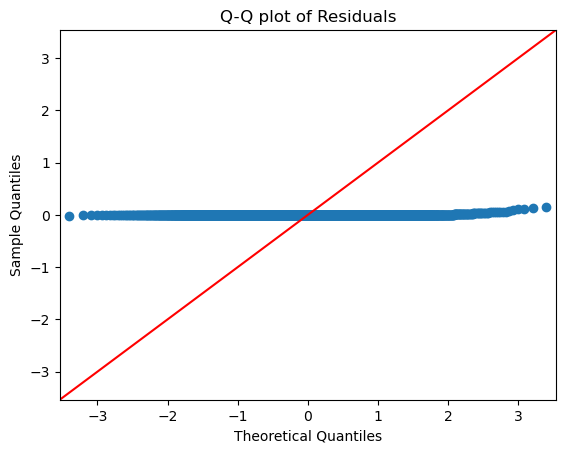

             feature        VIF
0             rating  17.245567
1        sentiment_c   9.556977
2   subjective_score  17.435595
3          elap_days   3.288895
4              image   1.109214
5          ver_purch  11.848322
6         word_count  11.234780
7         sent_count  13.525216
8        sent_length   4.862010
9       title_length   1.732842
10              #adj   2.823509
11              #adv   2.478554
12            #nouns   4.597921
13               FRE  17.872202


In [11]:
# Testing the assumptions of linear regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Linearity
# Plotting observed vs predicted values 
plt.scatter(y_test, y_pred)
plt.xlabel('Observed values')
plt.ylabel('Predicted values')
plt.title('Observed vs Predicted values')
plt.show()

# 2. Independence
# Durbin-Watson statistic for autocorrelation
from statsmodels.stats.stattools import durbin_watson
print('Durbin-Watson statistic:', durbin_watson(model_hedonic.resid))

# 3. Homoscedasticity
# Plotting residuals vs fitted values
plt.scatter(model_hedonic.fittedvalues, model_hedonic.resid)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# 4. Normality of Residuals
# Plotting histogram + Q-Q plot of residuals
sns.histplot(model_hedonic.resid, kde=True)
plt.title('Histogram of Residuals')
plt.show()

sm.qqplot(model_hedonic.resid, line ='45')
plt.title('Q-Q plot of Residuals')
plt.show()

# 5. No Multicollinearity
# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

## Regression Model on Product level 

In [12]:
# Define features and target
features = ['rating', 'sentiment_c', 'subjective_score', 'elap_days', 'image', 'ver_purch', 'word_count',
            'sent_count', 'sent_length', 'title_length', '#adj', '#adv', '#nouns', 'FRE']
target = 'helpful_ratio'

# Filter data to only include reviews with at least one helpful vote
perfume_data_hedonic = data_hedonic_helpful[data_hedonic_helpful['product'] == 'Perfume']
perfume_data_hedonic = perfume_data_hedonic[perfume_data_hedonic['helpful_vote'] > 2]

# Split data into training and testing sets
X = perfume_data_hedonic[features]
y = perfume_data_hedonic[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and fit the model using sklearn
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Interpret the results
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

# Add a constant to the features matrix for the intercept term
X_train_const = sm.add_constant(X_train_scaled)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y_train, X_train_const)
results = sm_model.fit()

# Get the summary of the regression results
print(results.summary())

# Extract p-values and identify significant features
p_values = results.pvalues
significant_features = p_values[p_values < 0.05].index
significant_features = significant_features[significant_features != 'const']  # Exclude the intercept
print("\nSignificant features based on p-values:")
print(significant_features)

Mean Squared Error: 6.690305896074173e-05
             Feature  Coefficient
0             rating     0.000835
1        sentiment_c    -0.000365
2   subjective_score    -0.000784
3          elap_days     0.002282
4              image     0.001403
5          ver_purch     0.000631
6         word_count     0.002874
7         sent_count    -0.000401
8        sent_length     0.000852
9       title_length     0.002092
10              #adj    -0.000081
11              #adv     0.001437
12            #nouns    -0.001497
13               FRE     0.000125
                            OLS Regression Results                            
Dep. Variable:          helpful_ratio   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.557
Date:                Mon, 27 May 2024   Prob (F-statistic):             0.0974
Time:                        09:06:32   Log-Likelihoo

In [13]:
# Filter data to only include reviews with at least one helpful vote
utilitarian_battery = data_utilitarian_helpful[data_utilitarian_helpful['product'] == 'Battery']

# Filter data to only include reviews with at least one helpful vote
utilitarian_battery = utilitarian_battery[utilitarian_battery['helpful_vote'] > 2]

# Split data into training and testing sets
X = utilitarian_battery[features]
y = utilitarian_battery[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and fit the model using sklearn
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Interpret the results
coefficients = pd.DataFrame({'Feature': features, 'Coefficient': model.coef_})
print(coefficients)

# Add a constant to the features matrix for the intercept term
X_train_const = sm.add_constant(X_train_scaled)

# Fit the linear regression model using statsmodels
sm_model = sm.OLS(y_train, X_train_const)
results = sm_model.fit()

# Get the summary of the regression results
print(results.summary())

# Extract p-values and identify significant features
p_values = results.pvalues
significant_features = p_values[p_values < 0.05].index
significant_features = significant_features[significant_features != 'const']  # Exclude the intercept
print("\nSignificant features based on p-values:")
print(significant_features)

Mean Squared Error: 0.0007435836223176948
             Feature  Coefficient
0             rating    -0.002832
1        sentiment_c    -0.004157
2   subjective_score     0.003919
3          elap_days     0.005384
4              image     0.002757
5          ver_purch     0.005698
6         word_count     0.024964
7         sent_count    -0.009871
8        sent_length    -0.005633
9       title_length     0.000447
10              #adj    -0.000507
11              #adv     0.001617
12            #nouns     0.000797
13               FRE     0.001841
                            OLS Regression Results                            
Dep. Variable:          helpful_ratio   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     1.821
Date:                Mon, 27 May 2024   Prob (F-statistic):             0.0442
Time:                        09:06:32   Log-Likelihoo

# 3. Regression on Main Category Level

In [14]:
# Define features and target
features = ['rating', 'sentiment_c', 'subjective_score', 'elap_days', 'image', 'ver_purch', 'word_count',
            'sent_count', 'sent_length', 'title_length', '#adj', '#adv', '#nouns', 'FRE']
target = 'helpful_ratio'

# Prepare a DataFrame to collect the results
results_df = pd.DataFrame(columns=['main_category', 'feature', 'coefficient', 'p_value', 'significant', 'MSE', 'R2'])

# Perform regression separately for each main category
for category in data_helpful['main_category'].unique():
    category_data = data_helpful[data_helpful['main_category'] == category]

    # Split data into training and testing sets
    X = category_data[features]
    y = category_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Add a constant to the features matrix for the intercept term
    X_train_const = sm.add_constant(X_train_scaled)

    # Fit the linear regression model using statsmodels
    sm_model = sm.OLS(y_train, X_train_const)
    results = sm_model.fit()

    # Calculate Mean Squared Error (MSE)
    X_test_const = sm.add_constant(X_test_scaled)
    y_pred = results.predict(X_test_const)
    mse = mean_squared_error(y_test, y_pred)

    # Calculate Adjusted R² (R²)
    r2 = results.rsquared_adj

    # Collect the results
    category_results_df = pd.DataFrame({
        'main_category': category,
        'feature': ['const'] + features,
        'coefficient': results.params.values,
        'p_value': results.pvalues.values,
        'significant': results.pvalues < 0.05,
        'MSE': mse,
        'R2': r2
    })

    results_df = pd.concat([results_df, category_results_df], ignore_index=True)

# Display the results
print(results_df)


    main_category           feature  coefficient       p_value significant  \
0       Household             const     0.001449  3.411699e-43        True   
1       Household            rating     0.000288  4.444464e-03        True   
2       Household       sentiment_c    -0.000129  1.851971e-01       False   
3       Household  subjective_score     0.000057  5.695547e-01       False   
4       Household         elap_days     0.000077  4.370453e-01       False   
..            ...               ...          ...           ...         ...   
115         Music      title_length     0.000390  2.490732e-01       False   
116         Music              #adj     0.000442  2.284655e-01       False   
117         Music              #adv    -0.000609  8.713956e-02       False   
118         Music            #nouns    -0.000661  7.611029e-02       False   
119         Music               FRE     0.000349  3.310917e-01       False   

          MSE        R2  
0    0.000006  0.208470  
1    0.0000